##**TITLE: FOREST CANOPY DENSITY DETECTION USING PYTHON**

All modules complete design

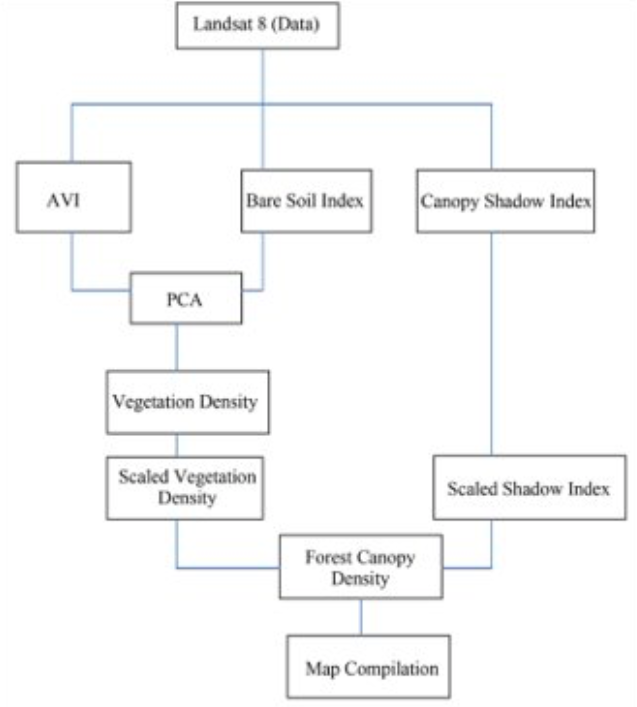

In [ ]:
#INSTALL REQUIRED LIBRARIES - GEEMAP,GDAL.
%%capture
!pip install geemap
!mkdir PCA_image
!mkdir PCA_output
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y #numpy and scipy are used got functioning of gdal
!pip install xarray_leaflet

In [ ]:
%%capture
#import libraries
%pylab inline
import geemap
import ee
import os
import gdal
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import numpy as np
import cv2
from matplotlib.pyplot import figure
!jupyter server --ServerApp.open_browser=True --ServerApp.default_url="voila/render/path_to_notebook.ipynb"


In [ ]:
#Authenticate google earth engine maps
Map=geemap.Map()
#Map

**MODULE-1** 

First we fetch Landsat raster imagery and GAUL feature collection. Then we input the district from the user. This input "district_name" is the **region of interest**.Then we filter out images between a range of dates. We have set the scale of computation to **90**. Then we create a median of the collection of images.
After we extract the image we develop some functions for basic image computation.


In [ ]:
#Fetching LandSat imagery and required feature collection 
#Here Landsat contains the raster image collection
#Districts contain vector data about states. We will use this vector data to filter region of intrest 
Landsat= ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
districts = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2");
district_name=input('Enter district name?') #input "Bangalore Urban" without quotes
district=districts.filter(ee.Filter.eq('ADM2_NAME', district_name))
roi=district.geometry()
startdate="2008-01-01" #We have taken a large span of dates to bring out the best image possible
lastdate= "2020-01-01"

scl=90 #Set the scale for band computation

image=Landsat.filterDate(startdate,lastdate)\
            .filterBounds(roi)\
            .median()\
            .clip(roi) 
            #FilterDate()-This filters the date span
            #FilterBounds()-This fetches only those images which contain our area of intrest
            #median()-This produces an image which median of all images. hence a sort of average image is produced
            #clip()-This clips our image to get our area of intrest

Enter district name?Bangalore Urban


In [ ]:
#Some functions for image computations.
#Scale is already declared

def getmin(image,band_name,mxpxls):
  mini=image.select(band_name).reduceRegion(
      reducer=ee.Reducer.min(),
      geometry=image.geometry(),
      scale=scl,
      maxPixels=mxpxls).getInfo().get(band_name)
  return mini

def getmax(image,band_name,mxpxls):
  maxi=image.select(band_name).reduceRegion(
      reducer=ee.Reducer.max(),
      geometry=image.geometry(),
      scale=scl,
      maxPixels=mxpxls).getInfo().get(band_name)
  return maxi
  
def getmean(image,band_name,mxpxls):
  meani=image.select(band_name).reduceRegion(
      reducer=ee.Reducer.mean(),
      geometry=image.geometry(),
      scale=scl,
      maxPixels=mxpxls).getInfo().get(band_name)
  return meani

def getstd(image,band_name,mxpxls):
  stdDevi=image.select(band_name).reduceRegion(
      reducer=ee.Reducer.stdDev(),
      geometry=image.geometry(),
      scale=scl,
      maxPixels=mxpxls).getInfo().get(band_name)
  return stdDevi

**MODULE2**

**NORMALIZATION TECHNIQUE**

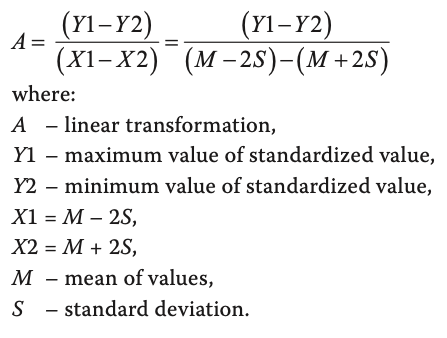

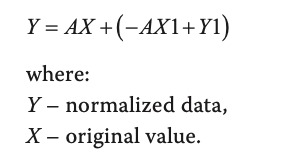

In [ ]:
#NORMALISE BANDS
#First we normalize our bands because.
meani2=getmean(image,'SR_B2',1e10)
stdi2=getstd(image,'SR_B2',1e10)

meani3=getmean(image,'SR_B3',1e10)
stdi3=getstd(image,'SR_B3',1e10)

meani4=getmean(image,'SR_B4',1e10)
stdi4=getstd(image,'SR_B4',1e10)

meani5=getmean(image,'SR_B5',1e10)
stdi5=getstd(image,'SR_B5',1e10)

meani7=getmean(image,'SR_B7',1e10)
stdi7=getstd(image,'SR_B7',1e10)



b2norm=image.select('SR_B2').multiply((20-220)/((meani2-2*stdi2)-(meani2+2*stdi2))).add(20).rename('b2norm')
b3norm=image.select('SR_B3').multiply((20-220)/((meani3-2*stdi3)-(meani3+2*stdi3))).add(20).rename('b3norm')
b4norm=image.select('SR_B4').multiply((20-220)/((meani4-2*stdi4)-(meani4+2*stdi4))).add(20).rename('b4norm')
b5norm=image.select('SR_B5').multiply((20-220)/((meani5-2*stdi5)-(meani5+2*stdi5))).add(20).rename('b5norm')
b7norm=image.select('SR_B7').multiply((20-220)/((meani7-2*stdi7)-(meani7+2*stdi7))).add(20).rename('b7norm')

image=image.addBands(b2norm).addBands(b3norm).addBands(b4norm).addBands(b5norm).addBands(b7norm) 

**MODULE-3**

**BAND COMPUTATION**

**Advanced vegetation index (AVI)**:When assessing the vegetation status of forests, the new methods first examine the characteristics of chlorophyll using a new Advanced Vegetation Index (AVI).

**Bare soil index (BI)**:The value of the vegetation index is not so reliable in situations where the vegetation covers less than half of the area. For more reliable estimation of the vegetation status, the new methods include bare soil index (BI) .

**Shadow index (SI)**:One unique characteristic of a forest is its three dimensional structure. To extract information on the forest structure from RS data, the new methods examine the characteristics of shadow by utilizing (a) spectral information on the forest shadow itself and (b) thermal information on the forest influenced by shadow. The shadow index is formulated through extraction of the low radiance of visible bands.

We segregate the calculated bands- AVI, BI, SI.
We visualize each of these bands.

#### We take formula of SI as ∛[(-1)*(65536-B2)*(65536-B3)*(65536-B2)]
####instead of ∛[(65536-B2)*(65536-B3)*(65536-B2)]
####as the latter is null and void.




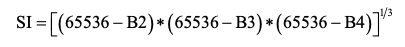

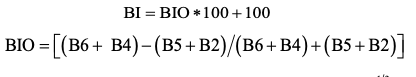

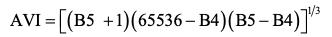

In [ ]:
#Here we calculate the required bands using our bands- SR_B2,SR_B3,SR_B4,SR_B5,SR_B6
#Here we calculate the required bands using our normalzed bands

avi=image.expression('((B5+1)*(65536-B4)*(B5-B4))**(1/3)',{
        'B5': image.select('SR_B5'),
        'B4': image.select('SR_B4'),}).rename('AVI')
bi=image.expression('((((B6+B4)-(B5+B2))/((B6+B4)+(B5+B2)))*100)+100',{
        'B6': image.select('ST_B6'),
        'B4': image.select('SR_B4'),
        'B2': image.select('SR_B2'),
        'B5':image.select('SR_B5')
}).rename('BI')
si=image.expression('((-1)*(256-B2)*(256-B3)*(256-B4))**(1/3)',{
        'B3': image.select('SR_B3'),
        'B2': image.select('SR_B3'),
        'B4': image.select('SR_B4')
}).rename('SI')
image=image.addBands(avi).addBands(bi).addBands(si)

In [ ]:
#We calculate th min-max range of calculated bands(AVI,SI,BI) for visualizing the maps
maxavi=getmax(image,'AVI',1e10)
minavi=getmin(image,'AVI',1e10)

maxbi=getmax(image,'BI',1e10)
minbi=getmin(image,'BI',1e10)

maxsi=getmax(image,'SI',1e10)
minsi=getmin(image,'SI',1e10)

maxti=getmax(image,'ST_TRAD',1e10)
minti=getmin(image,'ST_TRAD',1e10)

In [ ]:
#We Segregate the calculated bands(AVI,SI,BI) and visualize them
Aviimage=image.select(['AVI']).clip(roi)
Aviviz={
    'bands': ['AVI'],
    'max': maxavi,
    'min': minavi,
    'palette': ['green','red']
}
Map.addLayer(Aviimage,Aviviz,"IMAGE_AVI")
Biimage=image.select(['BI']).clip(roi)
Biviz={
    'bands': ['BI'],
    'max': maxbi,
    'min': minbi,
    'palette': ['blue','orange']
}
Map.addLayer(Biimage,Biviz,"IMAGE_BI")

Siimage=image.select(['SI']).clip(roi)
Siviz={
    'bands': ['SI'],
    'max': maxsi,
    'min': minsi,
    'palette': ['yellow','pink']
}
Map.addLayer(Siimage,Siviz,"IMAGE_SI")

Tiimage=image.select(['ST_TRAD']).clip(roi)
TIviz={
    'bands': ['ST_TRAD'],
    'max': maxti,
    'min': minti,
    'palette': ['brown','purple']
}
Map.addLayer(Tiimage,TIviz,"IMAGE_TI")


In [ ]:
Map.centerObject(roi, zoom=8)
Map

Map(center=[12.942208526432207, 77.5868323785926], controls=(WidgetControl(options=['position', 'transparent_b…

**MODULE 4**

In fourth module we do the prerquisite of Principal Component Analysis.Our images are in earth engine object format . We need to convert these earth engine object int tiff images with compression format 'ZSTD'. In 'ZSTD' format maximum amount of information is retained.We use GDAL library for this conversion.

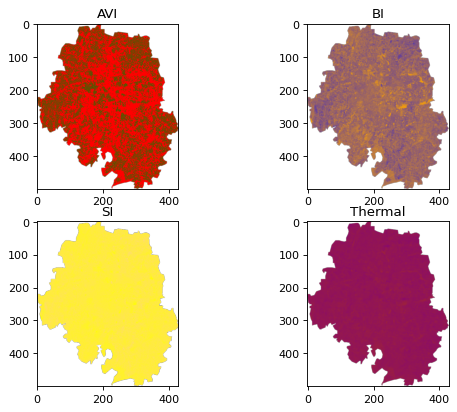

<Figure size 432x288 with 0 Axes>

In [ ]:
out_imgA = os.path.expanduser("/content/landsatAVI.png")
out_imgS = os.path.expanduser("/content/landsatSI.png")
out_imgB = os.path.expanduser("/content/landsatBI.png")
out_imgT = os.path.expanduser("/content/landsatT.png")
geemap.get_image_thumbnail(Aviimage, out_imgA, Aviviz, dimensions=500, format='png')
geemap.get_image_thumbnail(Siimage, out_imgS, Siviz, dimensions=500, format='png')
geemap.get_image_thumbnail(Tiimage, out_imgT, TIviz, dimensions=500, format='png')
geemap.get_image_thumbnail(Biimage, out_imgB, Biviz, dimensions=500, format='png')
img1 = mpimg.imread('/content/landsatAVI.png')
img2 = mpimg.imread('/content/landsatBI.png')
img3 = mpimg.imread('/content/landsatSI.png')
img4 = mpimg.imread('/content/landsatT.png')

figure(figsize=(8, 6), dpi=80)

fig = plt.figure()
plt.figure(1)

plt.subplot(221, title="AVI")
plt.imshow(img1)

plt.subplot(222,title="BI")
plt.imshow(img2)

plt.subplot(223,title="SI")
plt.imshow(img3)

plt.subplot(224,title="Thermal")
plt.imshow(img4)
plt.show()


####We will use Whitebox tool to perform PCA.
#### To use whitebox tools we need to compress tif files in '*PACKBITS*' format.

#### For this we first save the segregated bands then use GDAL library to apply 'PACKBITS' compression.

In [ ]:
#First we save the calculated bands(AVI,BI,SI) in colab directory , later we will use this saved images in PCA
%%capture
out_dir = os.path.join('/', 'content/PCA_image')
filename = os.path.join(out_dir, 'landsat.tif')
geemap.ee_export_image(Aviimage, filename=filename, scale=scl, region=roi, file_per_band=True)

out_dir = os.path.join('/', 'content/PCA_image')
filename = os.path.join(out_dir, 'landsat.tif')
geemap.ee_export_image(Biimage, filename=filename, scale=scl, region=roi, file_per_band=True)

out_dir = os.path.join('/', 'content/PCA_image')
filename = os.path.join(out_dir, 'landsat.tif')
geemap.ee_export_image(Siimage, filename=filename, scale=scl, region=roi, file_per_band=True)

out_dir = os.path.join('/', 'content/PCA_image')
filename = os.path.join(out_dir, 'landsat.tif')
geemap.ee_export_image(Tiimage, filename=filename, scale=scl, region=roi, file_per_band=True)

In [ ]:
"""USE GDAL to apply the compression because we will do PCA on band pair (AVI,BI) and band pair(SI,TI)  .
Geemap uses whitebox tools for PCA.
The PCA module in whitebox needs images in compression format ZSTD ,LZW, PACKBITS 
We take input from colabatory itself becuase we have saved the AVI, SI, TI ,BI in colabatory"""

gdalinput = '/content/PCA_image/landsat.AVI.tif'
gdaloutput = '/content/PCA_image/landsatnorm.AVI.tif'    
translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine("-of Gtiff -co COMPRESS=PACKBITS"))
gdal.Translate(gdaloutput, gdalinput, options=translateoptions)

gdalinput = '/content/PCA_image/landsat.BI.tif'
gdaloutput = '/content/PCA_image/landsatnorm.BI.tif'    
translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine("-of Gtiff -co COMPRESS=PACKBITS"))
gdal.Translate(gdaloutput, gdalinput, options=translateoptions)

gdalinput = '/content/PCA_image/landsat.SI.tif'
gdaloutput = '/content/PCA_image/landsatnorm.SI.tif'    
translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine("-of Gtiff -co COMPRESS=PACKBITS"))
gdal.Translate(gdaloutput, gdalinput, options=translateoptions)

gdalinput = '/content/PCA_image/landsat.ST_TRAD.tif'
gdaloutput = '/content/PCA_image/landsatnorm.ST_TRAD.tif'    
translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine("-of Gtiff -co COMPRESS=PACKBITS"))
gdal.Translate(gdaloutput, gdalinput, options=translateoptions)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f7001db50c0> >

**MODULE-5**

**PRINCIPAL COMPONENT ANALYSIS AND PRODUCTION OF FOREST CANOPY DENSITY MAP**

I found two ways to do PCA on images.
Whitebox module works with three or more input files.
But i need to do PCA on two bands

Second i found a javascript code of PCA. This javascript code works perfectly on google earth engine code editor. I converted it to python code. But everytime I run the code colab hits some dataexchage limit.

There's a third way as well .That is to integrate Qgis plugins in colab . I am still trying to find a way to do it.

In [ ]:
#PERFORM PCA to generate PCA component files
import whitebox
wbt = whitebox.WhiteboxTools()
wbt.work_dir = "/content/PCA_image" # Update this

print("Performing PCA...")
wbt.verbose = True  # We would like the PCA report to be automatically displayed
wbt.principal_component_analysis(
    inputs="landsatnorm.BI.tif;landsatnorm.SI.tif;landsatnorm.ST_TRAD.tif",
    output="pca_report.html",
    num_comp=7,
    standardized=False
)


Performing PCA...
./whitebox_tools --run="PrincipalComponentAnalysis" --wd="/content/PCA_image" --inputs='landsatnorm.BI.tif;landsatnorm.SI.tif;landsatnorm.ST_TRAD.tif' --output='pca_report.html' --num_comp='7'

*****************************************
* Welcome to PrincipalComponentAnalysis *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Calculating image means...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
P

0

In [ ]:
#Further computation using whitebox tool to produce the forrest canopy density map
for band_num in range(1, 4):
    print("Performing stretch on component {}".format(band_num))
    in_file = "PCA_component{}.tif".format(
        band_num)
    out_file = "PCA_component{}_cs.tif".format(
        band_num)
    wbt.percentage_contrast_stretch(
        i=in_file, output=out_file, clip=5.0, num_tones=1024)

print("Creating colour composites...")

wbt.create_colour_composite(
    red="PCA_component1_cs.tif",
    green="PCA_component2_cs.tif",
    blue="PCA_component3_cs.tif",
    output="PCA123RGB.tif",
    enhance=False,
)
print("All done!")


Performing stretch on component 1
./whitebox_tools --run="PercentageContrastStretch" --wd="/content/PCA_image" --input='PCA_component1.tif' --output='PCA_component1_cs.tif' --clip=5.0 --tail=both --num_tones=1024

****************************************
* Welcome to PercentageContrastStretch *
* Powered by WhiteboxTools             *
* www.whiteboxgeo.com                  *
****************************************
Reading input data...
Calculating clip values...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 

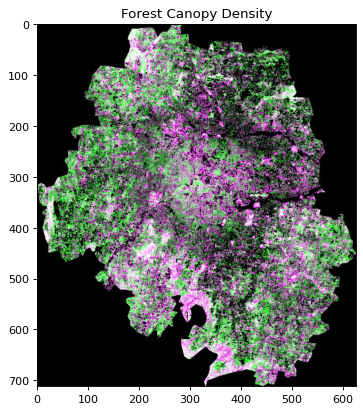

<Figure size 432x288 with 0 Axes>

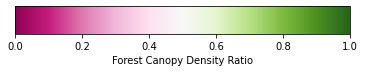

In [ ]:
outfile = "/content/PCA_result.jpeg"
im = Image.open("/content/PCA_image/PCA123RGB.tif")
out = im.convert("RGB")
out.save(outfile, "JPEG", quality=90)
img1 = mpimg.imread('/content/PCA_result.jpeg')
figure(figsize=(8, 6), dpi=80)

fig = plt.figure()
plt.figure(1)

plt.subplot(111, title="Forest Canopy Density")
plt.imshow(img1)

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.PiYG
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Forest Canopy Density Ratio')
plt.show()